# Blur-Cropper-Detector

Daniel Buscombe, Marda Science. Prepared for the SandSnap Project, Aug 18th, 2021

#### Problem: 
You have imagery that is blurred, and you wish to crop out the largest portion of the image you can that has, ideally, no blur

For example, this image below has blurred edges and I want to crop out the best region with no blur

![](samples/20210304_092138.jpg)

#### Proposed solution (for images of sediment and coins): 
1) window the image with overlap

2) compute the so-called BRISQUE image quality score ([Mittal et al., 2012](http://www.live.ece.utexas.edu/publications/2012/TIP%20BRISQUE.pdf)) for each image window

3) create a 2D heatmap of BRISQUE scores, and reduce edge effects following the method of [Pielawski and Wählby](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0229839) using a Hann taper with 50% overlap

4) use the Otsu method to determine the threshold between good and bad image scores, and binarize the 2D heatmap to make a 2D mask of good/bad portions of the image

5) crop out the largest square portion of the image 


Additionally, I show how to:

1) split up the large image further and write them to disk with no compression or chroma subsampling

2) flag blurry images in a set of images

These method assumes there is blur in the image and that it is the only source of noise or degradation that distinguishes the 'good' from 'bad' portions of the image. As such, BRISQUE score is considered proportional to degree of blur. According to the [authors](http://www.live.ece.utexas.edu/publications/2012/TIP%20BRISQUE.pdf), the BRISQUE is a compound metric of ...  

>... scene statistics of locally normalized luminance coefficients to quantify possible losses of “naturalness” in the image due to the presence of distortions

The method is entirely automated with no tunable parameters. As such, it may or may not work for you - please suggest improvements!

In the example, the best portions of the image, and also better whol images, are actually associated with the lowest Brisque scores, which was unexpected and remains unexplained. Brisque is an unconstrained metric - adapt this workflow to your own needs


### References
* Mittal, A., Moorthy, A. K., & Bovik, A. C. (2012). No-reference image quality assessment in the spatial domain. IEEE Transactions on Image Processing, 21(12), 4695-4708.

* Pielawski N, Wählby C (2020) Introducing Hann windows for reducing edge-effects in patch-based image segmentation. PLoS ONE 15(3): e0229839. https://doi.org/10.1371/journal.pone.0229839

### Acknowledgements
Thanks to Nicolas Pielawski for helping me implement their method - I have used functions provided by Nicolas [here](https://gist.github.com/npielawski/7e77d23209a5c415f55b95d4aba914f6). Thanks to my USGS colleague Chris Sherwood for turning me onto the Brisque metric and sharing [this excellent resource](https://github.com/ocampor/notebooks/blob/master/notebooks/image/quality/brisque.ipynb) with me

### Library imports

In [1]:
from skimage import io, img_as_float
from skimage.transform import rescale
from glob import glob
import imquality.brisque as brisque
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.signal.windows as w
from tqdm import tqdm
from math import log, ceil, floor, gcd
from skimage.filters import threshold_otsu
from numpy.lib.stride_tricks import as_strided as ast

`brisque` creates a lot of warnings from scikit-image. Suppress them with this code

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Functions

The following functions are from [here](https://gist.github.com/npielawski/7e77d23209a5c415f55b95d4aba914f6)

In [3]:
def window2d(window_func, window_size, **kwargs):
    '''
    Generates a 2D square image (of size window_size) containing a 2D user-defined
    window with values ranging from 0 to 1.
    It is possible to pass arguments to the window function by setting kwargs.
    All available windows: https://docs.scipy.org/doc/scipy/reference/signal.windows.html
    '''
    window = np.matrix(window_func(M=window_size, sym=False, **kwargs))
    return window.T.dot(window)

def generate_corner_windows(window_func, window_size, **kwargs):
    step = window_size >> 1
    window = window2d(window_func, window_size, **kwargs)
    window_u = np.vstack([np.tile(window[step:step+1, :], (step, 1)), window[step:, :]])
    window_b = np.vstack([window[:step, :], np.tile(window[step:step+1, :], (step, 1))])
    window_l = np.hstack([np.tile(window[:, step:step+1], (1, step)), window[:, step:]])
    window_r = np.hstack([window[:, :step], np.tile(window[:, step:step+1], (1, step))])
    window_ul = np.block([
        [np.ones((step, step)), window_u[:step, step:]],
        [window_l[step:, :step], window_l[step:, step:]]])
    window_ur = np.block([
        [window_u[:step, :step], np.ones((step, step))],
        [window_r[step:, :step], window_r[step:, step:]]])
    window_bl = np.block([
        [window_l[:step, :step], window_l[:step, step:]],
        [np.ones((step, step)), window_b[step:, step:]]])
    window_br = np.block([
        [window_r[:step, :step], window_r[:step, step:]],
        [window_b[step:, :step], np.ones((step, step))]])
    return np.array([
        [ window_ul, window_u, window_ur ],
        [ window_l,  window,   window_r  ],
        [ window_bl, window_b, window_br ],
    ])


def generate_patch_list(image_width, image_height, window_func, window_size, overlapping=False):
    patch_list = []
    if overlapping:
        step = window_size >> 1
        windows = generate_corner_windows(window_func, window_size)
        max_height = int(image_height/step - 1)*step
        max_width = int(image_width/step - 1)*step
    else:
        step = window_size
        windows = np.ones((window_size, window_size))
        max_height = int(image_height/step)*step
        max_width = int(image_width/step)*step
    for i in range(0, max_height, step):
        for j in range(0, max_width, step):
            if overlapping:
                # Close to border and corner cases
                # Default (1, 1) is regular center window
                border_x, border_y = 1, 1
                if i == 0: border_x = 0
                if j == 0: border_y = 0
                if i == max_height-step: border_x = 2
                if j == max_width-step: border_y = 2
                # Selecting the right window
                current_window = windows[border_x, border_y]
            else:
                current_window = windows
            # The patch is cropped when the patch size is not
            # a multiple of the image size.
            patch_height = window_size
            if i+patch_height > image_height:
                patch_height = image_height - i
            patch_width = window_size
            if j+patch_width > image_width:
                patch_width = image_width - j
            # Adding the patch
            patch_list.append(
                (j, i, patch_width, patch_height, current_window[:patch_height, :patch_width])
            )
    return patch_list

### Implementation

I start my implementation here. This function first crops any empty columns and rows, then it zero-pads both the image and mask so they are both square, then pass a sliding 64x64 pixel window across the image and further remove any small tiles with no 1s in the mask, while still maintaining a square image. As cropped as it can get while still containing the entire mask, and also square

In [4]:
#crop out the largest portion of image and mask with no zeros
def get_segment_crop(img,mask):
    
    #trim boundaries
    img = img[np.ix_(mask.any(1), mask.any(0))]
    mask = mask[np.ix_(mask.any(1), mask.any(0))]

    nxo, nyo = img.shape
    # make square by padding
    if nxo!=nyo:
        if nyo>nxo:
            try:
                img = np.hstack((np.zeros((nyo,nyo-nxo)), img))
                mask = np.hstack((np.zeros((nyo,nyo-nxo)), mask))
            except:
                img = np.vstack((np.zeros((nyo-nxo,nyo)), img))
                mask = np.vstack((np.zeros((nyo-nxo,nyo)), mask))                
        elif nxo>nyo:
            try:
                img = np.hstack((img, np.zeros((nxo,nxo-nyo))))
                mask = np.hstack((mask, np.zeros((nxo,nxo-nyo))))                
            except:
                img = np.vstack((img, np.zeros((nxo-nyo,nxo))))   
                mask = np.vstack((mask, np.zeros((nxo-nyo,nxo))))                   
        
    nx, ny = img.shape                
    winsize=64
    overlap = winsize 
    gridx, gridy = np.meshgrid(np.arange(nx),np.arange(ny))
    Z,_ = sliding_window(mask, (winsize,winsize), (overlap,overlap))
    Zy, _ = sliding_window(gridy, (winsize,winsize), (overlap,overlap))
    Zx, _ = sliding_window(gridx, (winsize,winsize), (overlap,overlap))
    
    mask = np.zeros_like(mask)
    for counter,z in enumerate(Z):
        if np.all(z==1):
            mask[Zx[counter],Zy[counter]]=1

    img = img[:nxo,:nyo]
    mask = mask[:nxo,:nyo]
    
    img = img[np.ix_(mask.any(1), mask.any(0))]
    mask = mask[np.ix_(mask.any(1), mask.any(0))]
    
    return img, mask

These next two functions are for sliding window operations and are used later

In [5]:
# =========================================================
def norm_shape(shap):
   '''
   Normalize numpy array shapes so they're always expressed as a tuple,
   even for one-dimensional shapes.
   '''
   try:
      i = int(shap)
      return (i,)
   except TypeError:
      # shape was not a number
      pass

   try:
      t = tuple(shap)
      return t
   except TypeError:
      # shape was not iterable
      pass

   raise TypeError('shape must be an int, or a tuple of ints')

# =========================================================
# Return a sliding window over a in any number of dimensions
# version with no memory mapping
def sliding_window(a,ws,ss = None,flatten = True):
    '''
    Return a sliding window over a in any number of dimensions
    '''
    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)
    # convert ws, ss, and a.shape to numpy arrays
    ws = np.array(ws)
    ss = np.array(ss)
    shap = np.array(a.shape)
    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shap),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shap):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\
 a.shape was %s and ws was %s' % (str(a.shape),str(ws)))
    # how many slices will there be in each dimension?
    newshape = norm_shape(((shap - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    a = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return a
    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    # remove any dimensions with size 1
    #dim = filter(lambda i : i != 1,dim)

    return a.reshape(dim), newshape

# #crop out the largest portion of image and mask with no zeros
# def get_segment_crop(img,mask):
#     return img[np.ix_(mask.any(1), mask.any(0))], mask[np.ix_(mask.any(1), mask.any(0))]

Below is a function to read an image, objectively determine an appropriate 2d tile size, and pad the image so it is square 

The tilesize to use with the Pielawski and Wählby (2020) method is determined as half the greatest common divisor of the two image dimensions

In [6]:
def get_image(impath, greyscale=True):
    img = img_as_float(io.imread(impath, as_gray=greyscale))

    # the tilesize to use with the overlapping taper method 
    nx, ny = img.shape
    TILESIZE = int(gcd(nx,ny)/2)

    # make square by padding
    if nx!=ny:
        if ny>nx:
            try:
                img = np.hstack((np.zeros((ny,ny-nx)), img))
            except:
                img = np.vstack((np.zeros((ny-nx,ny)), img))
        elif nx>ny:
            try:
                img = np.hstack((img, np.zeros((nx,nx-ny))))
            except:
                img = np.vstack((img, np.zeros((nx-ny,nx))))
                
        nx, ny = img.shape
    return img, nx, ny, TILESIZE

This function generates a heatmap of Brisque scores by combining for each tile with overlap and taper

In [7]:
def get_heatmap(img,nx,ny,TILESIZE,window_func):
    M = np.zeros((nx, ny)) # Output image
    patch_list = generate_patch_list(nx, ny, window_func, TILESIZE, use_hanning)
    for patch in tqdm(patch_list):
        patch_x, patch_y, patch_width, patch_height, window = patch
        # We generate our prediction
        img_tile = img[patch_y:patch_y+patch_height, patch_x:patch_x+patch_width]
        if np.max(img_tile)<.01:
            prediction = 0.0
        else:
            prediction = brisque.score(img_tile)

        M[patch_y:patch_y+patch_height, patch_x:patch_x+patch_width] += (np.ones_like(window)*prediction) * window
    return M

The image padding is removed, and the Otsu threshold computed for converting the Brisque scores into a binary mask of good/not good data

optionally, if `conservative=True` the threshold is halved, to get a smaller and more robust 'good' data mask

In [8]:
def threshold_heatmap(impath,M, conservative=True, greyscale=True):
    img = img_as_float(io.imread(impath, as_gray=greyscale))
    if greyscale:
        nx, ny = img.shape
    else:
        nx, ny, _ = img.shape
    M = M[:nx,:ny]
    M[M<0] = 0
    thres = threshold_otsu(M)
    
    # optionally, be conservative and divide the threshold by 2
    if conservative:
        thres = thres/2

    print("Otsu threshold is %f"% (thres))

    return M, thres, img

Make an plot a 4-part figure showing a) original image, 2) mask, 3) cropped image, and 4) cropped mask

In [9]:
def get_fig(img, mask, thres, img_cropped, M_cropped):
    fig = plt.figure(figsize=(12,12))

    plt.subplot(221)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, alpha=0.25, cmap='bwr')

    plt.subplot(222)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask<thres, alpha=0.25, cmap='bwr')

    plt.subplot(223)
    plt.imshow(img_cropped, cmap='gray')
    plt.imshow(M_cropped, alpha=0.25, cmap='bwr')

    plt.subplot(224)
    plt.imshow(img_cropped, cmap='gray')
    return fig

### Example: cropping the image to the least blurred portion

We choose a Hanning window, which is ~4 times slower, but better quality, according to [this](https://gist.github.com/npielawski/7e77d23209a5c415f55b95d4aba914f6)

In [10]:
# Using the hanning windows
use_hanning = True
window_func = w.hann

Test image

In [11]:
impath = r'samples/20210304_092138.jpg'

In [12]:
img, nx, ny, TILESIZE = get_image(impath)

In [13]:
print(TILESIZE)

504


The image is significantly blurred on the outside but usable in the center

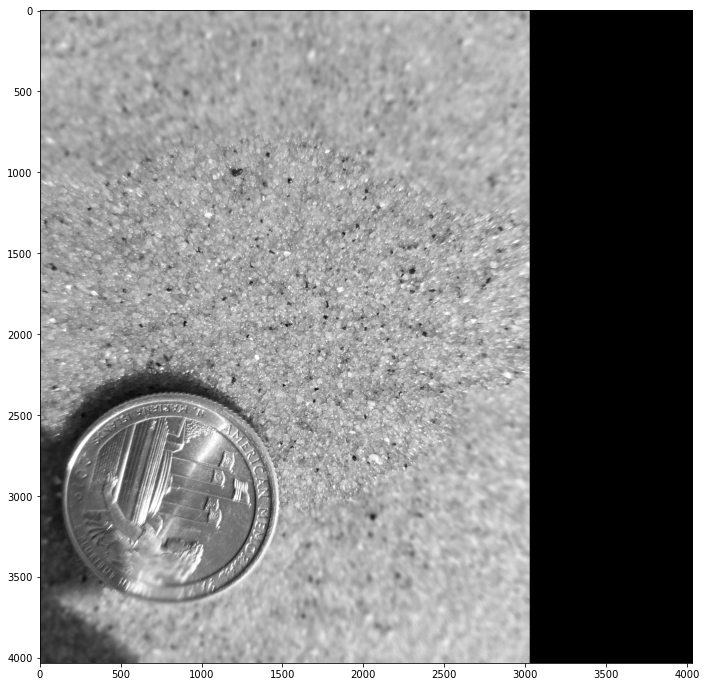

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(img, cmap='gray')

This is slow on large images with the hann taper (below we explore a much faster method)

In [15]:
M = get_heatmap(img,nx,ny, TILESIZE, window_func)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [02:54<00:00,  1.29it/s]


Trim the mask and image and return the Otsu threshold

In [16]:
mask, thres, img = threshold_heatmap(impath,M, conservative=False)
del M

Otsu threshold is 36.653907


Crop to the extent of the mask

In [17]:
img_cropped, M_cropped = get_segment_crop(img,mask=mask<thres)

Make and plot a figure

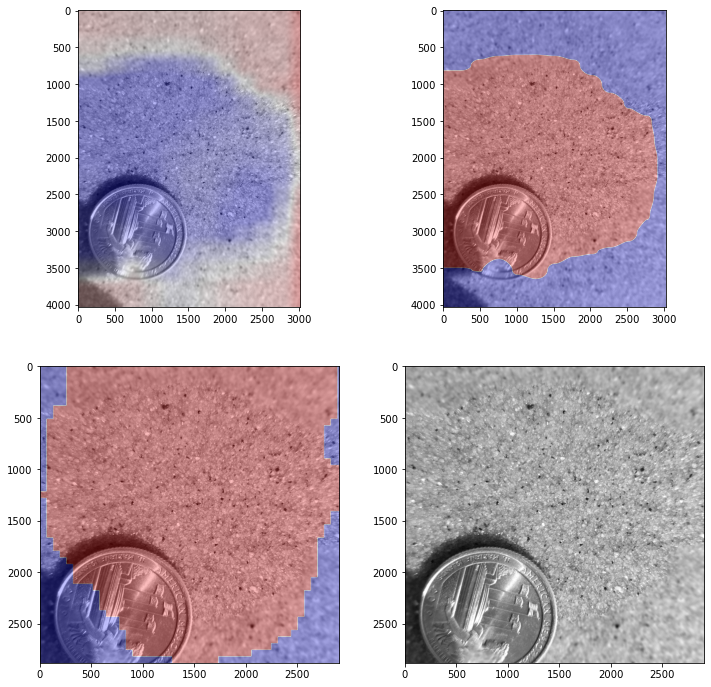

In [18]:
fig = get_fig(img, mask, thres, img_cropped, M_cropped)

### Example with a quicker taper

The Hanning window is a little slow because of the overlap- could we get similar performance with the Bartlett filter?

In [19]:
# Using the Bartlett-Hann window
use_hanning = False #True
window_func = w.barthann #w.hann

In [20]:
img, nx, ny, TILESIZE = get_image(impath)
M = get_heatmap(img,nx,ny, TILESIZE,window_func)
mask, thres, img = threshold_heatmap(impath,M, conservative=False)
del M
img_cropped, M_cropped = get_segment_crop(img,mask=mask<thres)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:47<00:00,  1.34it/s]


Otsu threshold is 34.121982


Much, much faster! Is it as good?

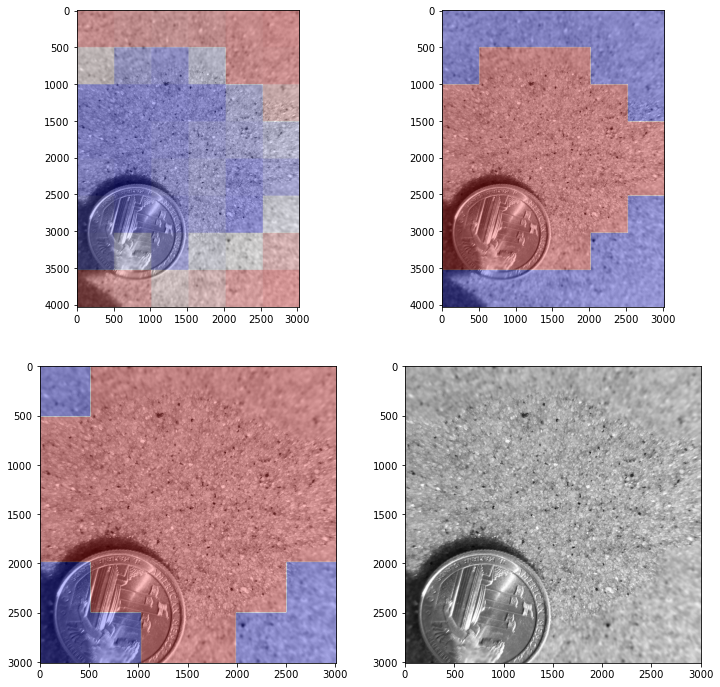

In [21]:
fig = get_fig(img, mask, thres, img_cropped, M_cropped)

Not identical, but similar enough

### Example: tiling the cropped image and selecting the best squares

Get square windows of data of given size (1024x1024 pixels) with 50% overlap

In [22]:
IM_HEIGHT = 1024
IM_WIDTH = IM_HEIGHT 

Z,_ = sliding_window(img_cropped, (IM_HEIGHT,IM_WIDTH), (int(IM_HEIGHT/2),int(IM_WIDTH/2)))

In [23]:
Z[0].shape

(1024, 1024)

Make a plot of each window with the associated Brisque score

color the highest scores (above the 75th percentile) red and the lower scores green

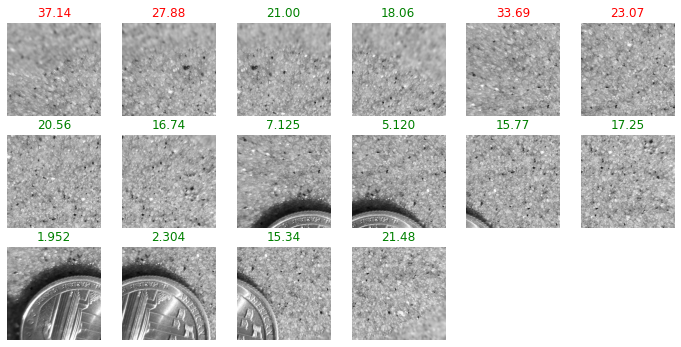

In [24]:
plt.figure(figsize=(12,12))

S=[]
for counter, z in enumerate(Z):
    plt.subplot(6,6,counter+1)
    plt.imshow(z, cmap='gray'); plt.axis('off')
    z = rescale(z,.125,anti_aliasing=True)
    score = brisque.score(z)
    S.append(score)

sthres = np.percentile(S,75) #median(S)
for counter, z in enumerate(Z):
    plt.subplot(6,6,counter+1)    
    if S[counter]<sthres:
        plt.title(str(S[counter])[:5], color='g')        
    else:
        plt.title(str(S[counter])[:5], color='r')

Get a list of just the 'best' image tiles 

In [25]:
Zbest = [z for z,s in zip(Z,S) if s<sthres]

How many?

In [26]:
len(Zbest)

12

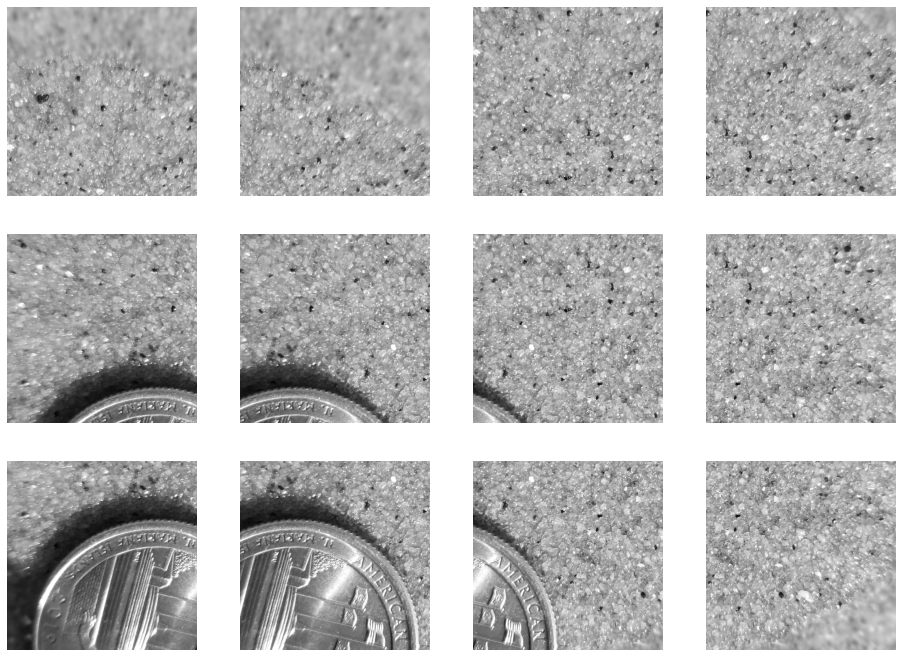

In [27]:
plt.figure(figsize=(16,16))
for counter, z in enumerate(Zbest):
    plt.subplot(4,4,counter+1)
    plt.imshow(z, cmap='gray'); plt.axis('off')

That looks encouraging - these are most in-focus image tiles in the scene

### Example: Writing image tiles to file

Disable chroma subsampling and use the highest quality for jpegs

In [30]:
for counter, z in enumerate(Zbest):
    root = impath.split('/')[-1].split('.')[0]
    if counter<10:
        io.imsave('blur_test/results/%s_000%i.jpg'%(root,counter), 
                  (255*z).astype('uint8'), quality=100, chroma_subsampling=False)
    elif (counter>10) and (counter<100):
        io.imsave('blur_test/results/%s_00%i.jpg'%(root,counter), 
                  (255*z).astype('uint8'), quality=100, chroma_subsampling=False)        
    elif (counter>100) and (counter<1000):
        io.imsave('blur_test/results/%s_0%i.jpg'%(root,counter), 
                  (255*z).astype('uint8'), quality=100, chroma_subsampling=False)        

pngs are also good. No compression would be

In [31]:
for counter, z in enumerate(Zbest):
    root = impath.split('/')[-1].split('.')[0]
    if counter<10:
        io.imsave('blur_test/results/%s_000%i.png'%(root,counter), 
                  (255*z).astype('uint8'), compression=0)
    elif (counter>10) and (counter<100):
        io.imsave('blur_test/results/%s_00%i.png'%(root,counter), 
                  (255*z).astype('uint8'), compression=0)        
    elif (counter>100) and (counter<1000):
        io.imsave('blur_test/results/%s_0%i.png'%(root,counter), 
                  (255*z).astype('uint8'), compression=0)    

### Example: Batch process the within-image blur detection

Ok, now we need to test this on a few images. We need a single function call for the initial cropping ... 

In [32]:
def get_cropped_image(impath, window_func):
    img, nx, ny, TILESIZE = get_image(impath)
    M = get_heatmap(img,nx,ny, TILESIZE,window_func)
    mask, thres, img = threshold_heatmap(impath,M, conservative=False)
    img_cropped, M_cropped = get_segment_crop(img,mask=mask<thres)
    fig = get_fig(img, mask, thres, img_cropped, M_cropped)
    return img_cropped

and a single function call for the image tiling. The downsample is necessary for speed, but note that you get slightly different scores with different sized (resolution) imagery

In [33]:
def get_best_tiles(img_cropped, IM_HEIGHT, prc=75, downsample=1/8):
    IM_WIDTH = IM_HEIGHT
    Z,_ = sliding_window(img_cropped, (IM_HEIGHT,IM_WIDTH), (int(IM_HEIGHT/2),int(IM_WIDTH/2)))

    S = []
    for counter, z in enumerate(Z):
        z = rescale(z,downsample,anti_aliasing=True)
        score = brisque.score(z)
        S.append(score)

    sthres = np.percentile(S,prc) 
    return [z for z,s in zip(Z,S) if s<sthres]

First we'll test just the cropping portion

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:47<00:00,  1.33it/s]


Otsu threshold is 13.029028


(-0.5, 3023.5, 3007.5, -0.5)

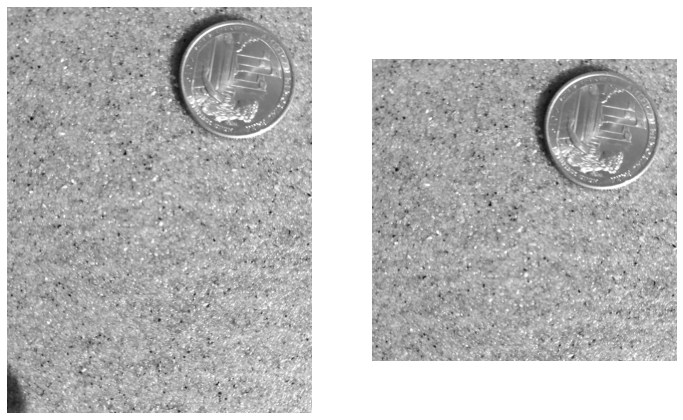

In [34]:
files = glob('samples/2021*.jpg')

file = files[0]
img = get_cropped_image(file, window_func)
plt.subplot(121); plt.imshow(img_as_float(io.imread(file, as_gray=True)), cmap='gray')
plt.axis('off')
plt.subplot(122); plt.imshow(img, cmap='gray')
plt.axis('off')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:47<00:00,  1.35it/s]


Otsu threshold is 39.569347


(-0.5, 3007.5, 3007.5, -0.5)

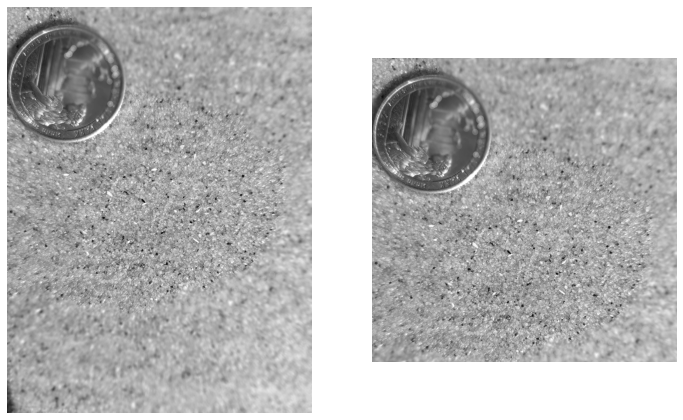

In [35]:
file = files[-1]
img = get_cropped_image(file, window_func)
plt.subplot(121); plt.imshow(img_as_float(io.imread(file, as_gray=True)), cmap='gray')
plt.axis('off')
plt.subplot(122); plt.imshow(img, cmap='gray')
plt.axis('off')

Looks pretty decent... let's trial the tiling portion ...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:47<00:00,  1.34it/s]


Otsu threshold is 39.569347


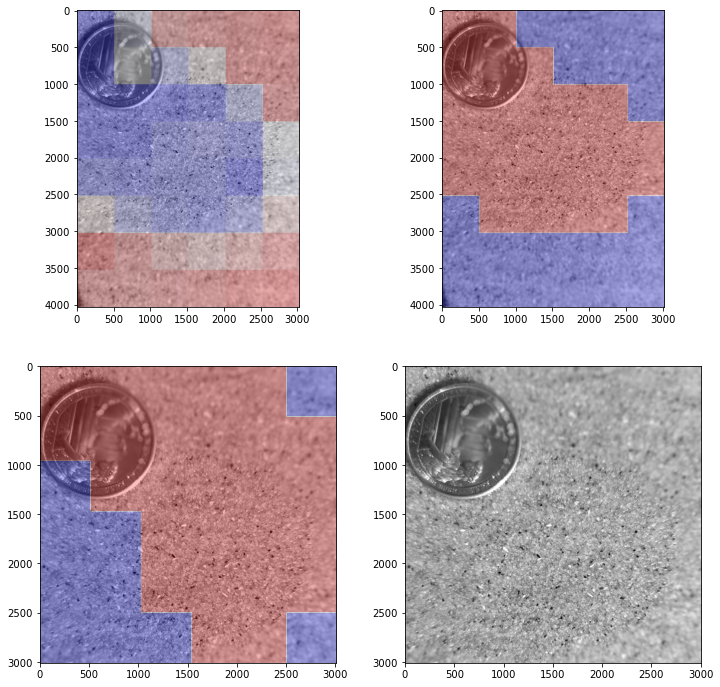

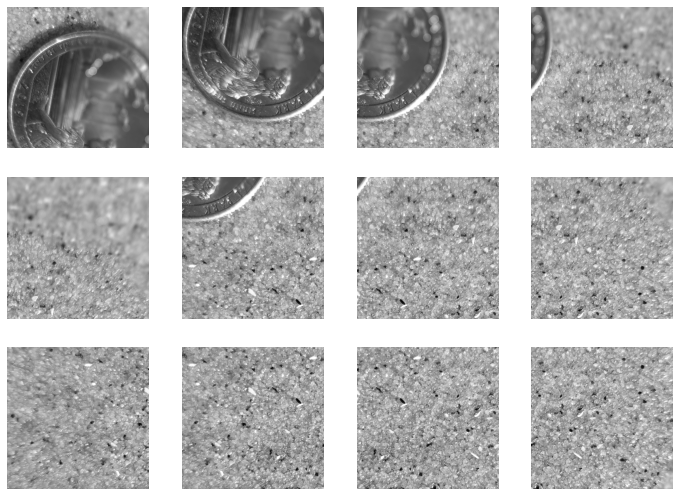

In [36]:
file = files[-1]
img = get_cropped_image(file, window_func)
best_tiles = get_best_tiles(img, IM_HEIGHT, prc=75, downsample=1/8)
if len(best_tiles)>16:
    best_tiles = best_tiles[:16]
plt.figure(figsize=(12,12))
for counter, z in enumerate(best_tiles):
    plt.subplot(4,4,counter+1)
    plt.imshow(z, cmap='gray'); plt.axis('off') 

### Example: weeding out bad images in a set

Now we want to identify the bad images in a set - first read them in (in practice, you should read them in one by one and just evaluate the Brisque score on the fly, but here I only have 4 images and want to make plots)

In [37]:
images = [ img_as_float(io.imread(file, as_gray=True)) for file in sorted(glob('blur_test/*.jpg'))]

look at the images

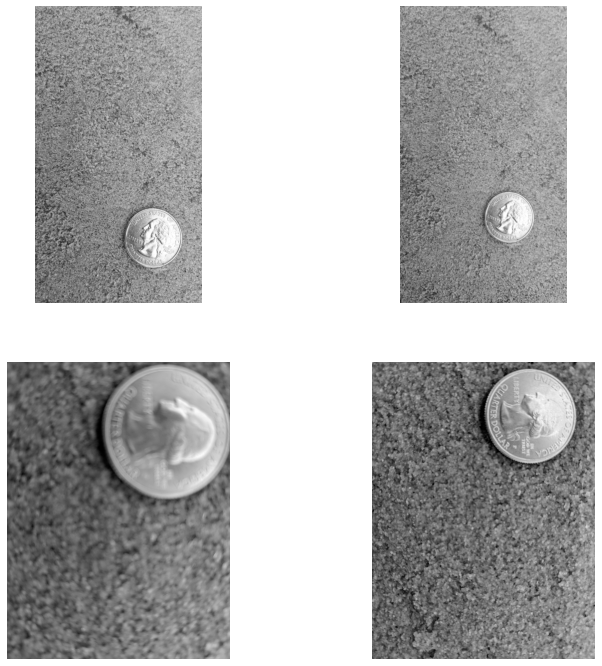

In [38]:
plt.figure(figsize=(12,12))
for counter, g in enumerate(images):
    plt.subplot(2,2,counter+1); plt.imshow(g, cmap='gray'); plt.axis('off')    

bottom left is blurry - can we detect it?

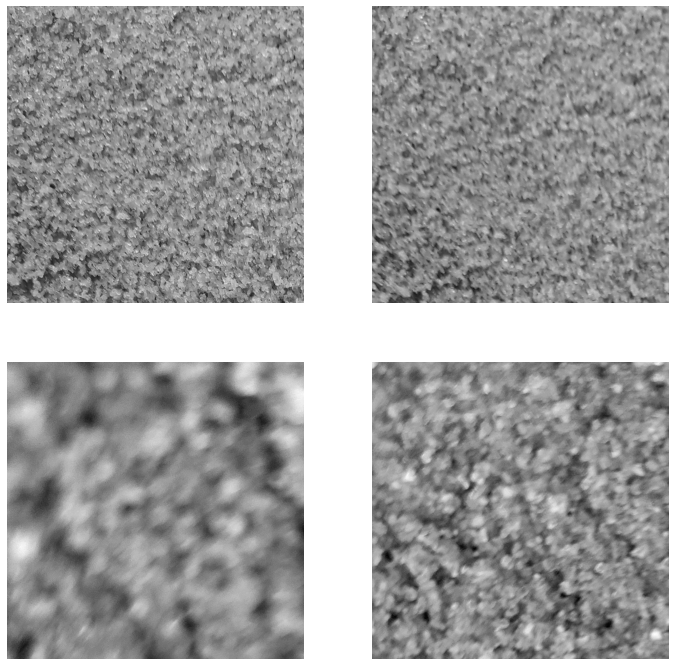

In [39]:
plt.figure(figsize=(12,12))
for counter, g in enumerate(images):
    plt.subplot(2,2,counter+1); plt.imshow(g[:1000,:1000], cmap='gray'); plt.axis('off') 

In [40]:
scores = [brisque.score(rescale(g,.125,anti_aliasing=True)) for g in images] 

In [41]:
print(scores)

[19.97737872152149, 18.170119269389687, 54.91925871344037, 37.39072028732218]


Yes, it has the highest score  (54.9)

Text(0.5, 1.0, 'score: 37.39')

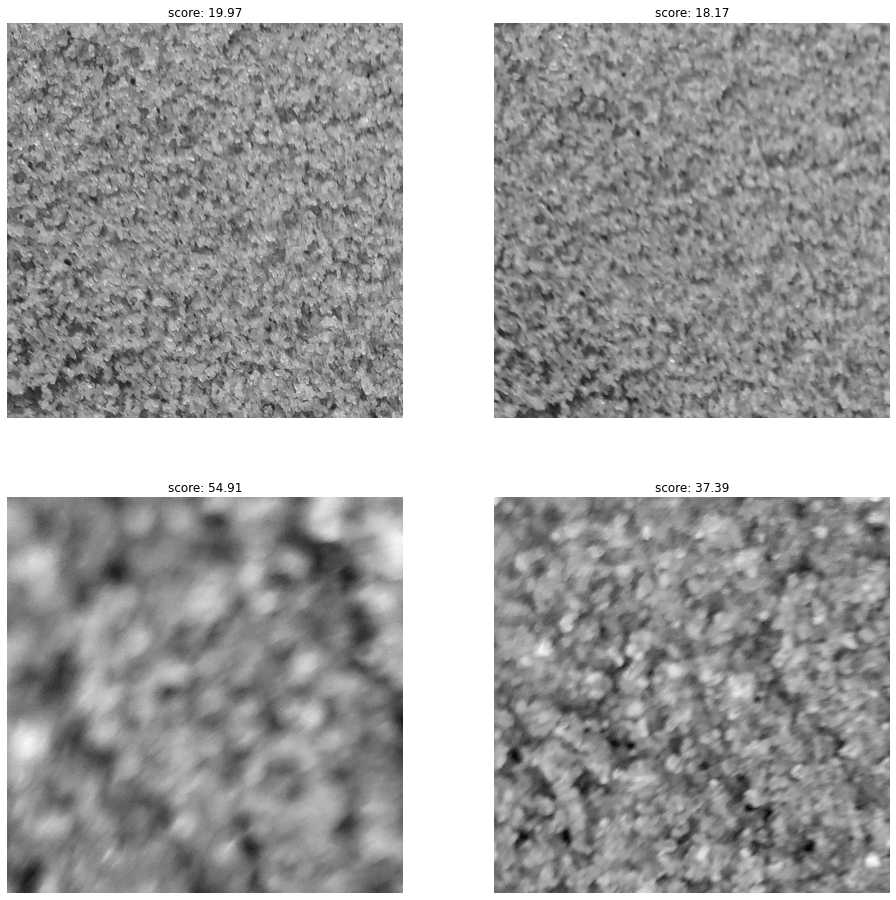

In [42]:
plt.figure(figsize=(16,16))
plt.subplot(221);
plt.imshow(images[0][:1000,:1000], cmap='gray'); plt.axis('off'); plt.title('score: %s'%(str(scores[0])[:5]))

plt.subplot(222);
plt.imshow(images[1][:1000,:1000], cmap='gray'); plt.axis('off'); plt.title('score: %s'%(str(scores[1])[:5]))

plt.subplot(223);
plt.imshow(images[2][:1000,:1000], cmap='gray'); plt.axis('off'); plt.title('score: %s'%(str(scores[2])[:5]))

plt.subplot(224);
plt.imshow(images[3][:1000,:1000], cmap='gray'); plt.axis('off'); plt.title('score: %s'%(str(scores[3])[:5]))


That's good - we have a method that may detect blurry samples, with higher BRISQUE scores - the threshold here appears to be somewhere between 37 and 54. Remember is this affect by the scale, so this metric is only comparabale with imagery downsampled by the same amount (I used a factor of 8)